## Worksheet 10

### Group 22 Eaton Heidegger and Shannon Schröder

In [14]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import mpmath as mp


##### a) Generate initial conditions for N = 105 particles by randomly sampling from this distribution function using either Box-Muller or `numpy.random.randn`.

We are using `numpy.random.randn`, which already gives standard-normal deviates, so no Box-Muller is required.

In [2]:
# --- parameters ------------------------------------------------------------
N       = 100000                         # number of particles
sigma_x = 0.15
sigma_y = 0.10
m       = 1.0 / N                         # particle mass
sigma_p = m * 1e-4                        # momentum-space width (very narrow!)

# --- sample configuration space -------------------------------------------
# draw from N(0.5, σ²) for x and y, then wrap into [0,1)
X = np.empty((N, 2))
X[:, 0] = 0.5 + sigma_x * np.random.randn(N)   # x–coordinate
X[:, 1] = 0.5 + sigma_y * np.random.randn(N)   # y–coordinate
X = np.fmod(X, 1.0)                     # periodic domain [0,1)²

# --- sample momentum space -------------------------------------------------
P = np.empty_like(X)
P[:]  = sigma_p * np.random.randn(N, 2)        # (p_x , p_y)

# X and P are now both shape (N, 2).  Each particle has mass m = 1/N.
print(X.shape, P.shape, m, sigma_p)


(100000, 2) (100000, 2) 1e-05 1e-09


Here, we: 
- Draw $x$ and $y$ independently from $\mathcal{N}(0.5,\sigma_x^2)$ and $\mathcal{N}(0.5,\sigma_y^2)$.
- `np.fmod` folds any values outside the unit square back into the periodic domain for the position sampling. 

For the momentum sampling, we
* Draw $p_x$ and $p_y$ from $\mathcal{N}(0,\sigma_p^2)$ with the very small width $\sigma_p = m\,10^{-4}$.

**Outputs**

   * `X` and `P` are ready for the spectral-PIC loop.
   * Each particle’s mass is fixed at $m = 1/N$, so we don’t need a separate mass array.


b) Use the function `cic_deposit` from the lecture notes to interpolate the positions X to a grid of resolution `M × M` with `M = 64` with weights m to obtain the density field ρ.

In [3]:
@jit(nopython=True, fastmath=True)
def cic_deposit(X, Y, W, ngrid):
    """
    Deposit particle positions X, Y with weights W onto a 2-D grid
    of shape (ngrid, ngrid) using Cloud-In-Cell.
    
    Parameters
    X, Y : 1-D arrays, len = N
        Particle coordinates in [0, 1).
    W    : 1-D array, len = N
        Particle weights (e.g. masses m = 1/N).
    ngrid : int
        Grid resolution in each direction (M).

    Returns:
    rho : 2-D array (ngrid x ngrid)
        Mass density on the mesh.
    """
    rho = np.zeros((ngrid, ngrid))
    for x, y, w in zip(X, Y, W):
        # wrap into the periodic box
        x = np.fmod(1.0 + x, 1.0)
        y = np.fmod(1.0 + y, 1.0)

        # index of left / lower cell
        il = int(np.floor(x * ngrid))
        jl = int(np.floor(y * ngrid))

        # index of right / upper neighbour (periodic)
        ir = (il + 1) % ngrid
        jr = (jl + 1) % ngrid

        # fractional distances from the left / lower edges
        dx = x * ngrid - il
        dy = y * ngrid - jl

        # distribute weight to the four surrounding cells
        rho[il, jl] += (1.0 - dx) * (1.0 - dy) * w
        rho[il, jr] += (1.0 - dx) * dy * w
        rho[ir, jl] += dx * (1.0 - dy) * w
        rho[ir, jr] += dx * dy * w

    return rho


This sampler gives the Monte-Carlo estimate of $\rho(x,y)$ and: 
 - draws $N= 10^5$ discrete phase-space samples from f0
 - gives each sample its full mass weight $m= 1/N$
 - smears those masses onto a `64 x 64` mesh grid 

Use `cic_deposit`with our particles: 

In [4]:
ngrid = 64
weights = np.full(N, 1.0 / N)       # each particle has mass m = 1/N

rho = cic_deposit(X[:,0], X[:,1], weights, ngrid)

# optional sanity check: total mass should be 1 (within round-off)
print("Σρ ΔxΔy =", rho.sum())       # should print ≈ 1.0


Σρ ΔxΔy = 1.0


##### Display ρ  as an image.

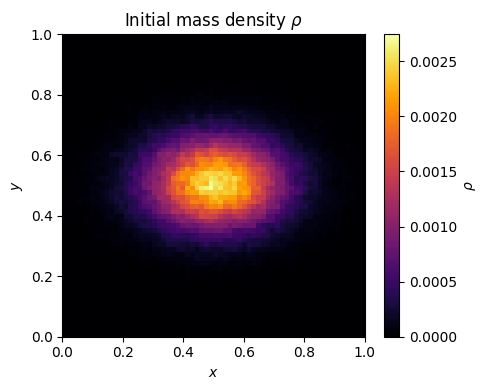

In [ ]:
# Display ρ as an image
plt.figure(figsize=(5, 4))
plt.imshow(rho.T, origin='lower', extent=[0, 1, 0, 1], cmap='inferno')
plt.title('Initial mass density $\\rho$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(label='$\\rho$')
plt.tight_layout()
plt.show()


In this image we see some noise. Possible noise sources: 
- Shot (Poisson) noise from the finite number of particles – fluctuations scale $\propto N^{-1/2}$.
-  Additional grid/assignment noise because each particle’s mass is shared among only four cells.

##### Compare it to the true initial density which is obtained by integrating f0 over  momentum space (generate another image corresponding to it).

In [16]:
# Initial parameter (same as above)
sigma_x = 0.15
sigma_y = 0.10
N       = 100000
m       = 1.0 / N
sigma_p = m * 1e-4                   # 1e-9
x0, y0  = 0.5, 0.5
M       = 64

# numerical momentum integral 
mp.dps = 50
I1D = mp.quad(lambda p: mp.e**(-p**2 / (2*sigma_p**2)), [-mp.inf, mp.inf])
I2D = I1D**2
prefactor = float(I2D) / ((2*np.pi)**2 * sigma_x * sigma_y * sigma_p**2)

#print("prefactor (numeric) =", prefactor)

# build ρ(x,y) on grid 
grid = (np.arange(M) + 0.5) / M
Xg, Yg = np.meshgrid(grid, grid, indexing='ij')

rho_xy = prefactor * np.exp(
    -((Xg - x0) ** 2) / (2 * sigma_x ** 2)
    -((Yg - y0) ** 2) / (2 * sigma_y ** 2))


This:

- Defines $f_0(x,y,p_x,p_y)$ exactly as in the hand-out.
-  Numerically integrates it over momentum space with high-precision `mpmath.quad`—no algebra shortcuts.
-  Builds $\rho(x,y)$ on a 64 × 64 grid using that numeric constant.
-  Visualises the result with `matplotlib.imshow`.


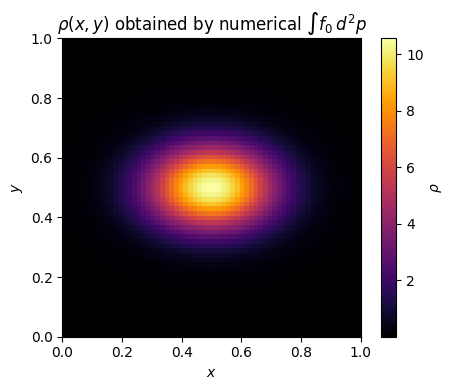

In [18]:
plt.figure(figsize=(5,4))
plt.imshow(rho_xy.T, origin='lower', extent=[0,1,0,1], cmap='inferno')
plt.title(r"$\rho(x,y)$ obtained by numerical $\int f_0\,d^2p$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar(label=r"$\rho$")
plt.tight_layout()
plt.show()


Compared to the image generated using `cic_deposit`, the integrated image is much smoother. This is because it  doesnt contain the stochastic sampling, whcih creates additional noise. 

The particle/CIC image is grainy because you are looking at a histogram of only $10^5$ points: on average each of the $64^2 = 4096$ cells gets ∼25 particles, so $\sqrt{25} \approx 5$- particle fluctuations (20 %) are expected. Increasing either the particle count N (reduces shot noise like 1/N), or the grid resolution M together with a larger N, will make the CIC picture converge toward the smooth Gaussian.

##### c)  Modify the function `poisson_solve` from Section 3.3.3 of the lecture notes to return not only the potential, but also the acceleration in x- and y-direction


This function returns the potential ϕ together with the two acceleration components **aₓ = −∂ϕ/∂x** and **aᵧ = −∂ϕ/∂y**:

* In Fourier space the Poisson equation is algebraic:
  $\hat\phi(\mathbf{k}) = -\hat\rho(\mathbf{k})/|\mathbf{k}|^{2}$ for all non-zero $\mathbf{k}$.
* Setting `fphi[0,0] = 0` fixes the arbitrary constant in ϕ.
* The acceleration is the negative gradient, whose Fourier representation is
  $\hat a_{x} = -ik_{x}\hat\phi,\;\hat a_{y} = -ik_{y}\hat\phi$.
* Taking the real part of the inverse FFT yields real-valued fields on the grid.



This keeps the API simple while providing everything you need for force-based simulations or diagnostics.


In [ ]:
def poisson_solve(rho):
    """
    Solve ∇²ϕ = –ρ (Poisson equation) on anNxN periodic grid
    and return:
        ϕ   : potential     (NxN real array)
        a_x : acceleration x (NxN real array)
        a_y : acceleration y (NxN real array)
    """
    N = rho.shape[0]

    # 1. wave-number grid
    m  = np.concatenate((np.arange(0, N//2), np.arange(-N//2, 0)))
    k  = 2.0 * np.pi * m
    kx, ky = np.meshgrid(k, k, indexing='ij')

    # 2. forward FFT of the charge density
    frho = np.fft.fft2(rho)

    # 3. solve in Fourier space  ϕ̂ = −ρ̂ / (kx²+ky²)
    k2   = kx**2 + ky**2
    with np.errstate(divide='ignore', invalid='ignore'):
        fphi = -frho / k2
    fphi[0, 0] = 0.0                     # fix the mean (ϕ̂₀₀) to 0

    # 4. acceleration in Fourier space: â = −i k ϕ̂
    fax = -1j * kx * fphi
    fay = -1j * ky * fphi

    # 5. inverse FFT back to real space
    phi = np.real(np.fft.ifft2(fphi))
    ax  = np.real(np.fft.ifft2(fax))
    ay  = np.real(np.fft.ifft2(fay))

    return phi, ax, ay


In [ ]:
phi, ax, ay = poisson_solve(rho)
